# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [338]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [339]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [340]:
#your turn
df_offers_acc = df_transactions.merge(pd.get_dummies(df_transactions['offer_id']), left_index=True, right_index=True)
df_offers_acc.drop(columns=['offer_id','n'], inplace=True)
df_cust_offers = pd.pivot_table(df_offers_acc, values=range(1, 32), index='customer_name', aggfunc=np.sum)
df_cust_offers.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Ideally we want tight bunched clusters which means that the smaller the SS values the better.

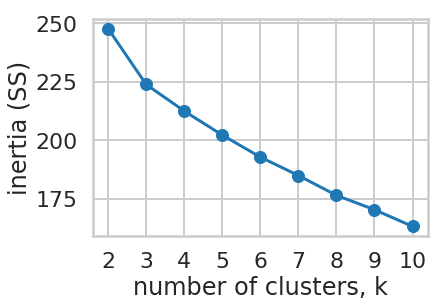

In [34]:
# your turn
x_cols = df_cust_offers

ks = range(2, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=1)
    
    # Fit model to samples
    model.fit(x_cols)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia (SS)')
plt.xticks(ks)
plt.show()

For this particular plot above I would say at k=3 is when the plot stops decreasing as much as in previous ks. However, if you don't set a random_state parameter, then the results differ slightly suggesting other k values. If I had to pick a k value from this method I would pick k=3, but looking at the varying results without setting a random_seed number, there doesn't seem to be a clear elbow point, as it seems to vary from 3 <= k <= 5.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09509821910863496
For n_clusters = 3 The average silhouette_score is : 0.12371369148180854
For n_clusters = 4 The average silhouette_score is : 0.1273814104883065
For n_clusters = 5 The average silhouette_score is : 0.14325381203579995
For n_clusters = 6 The average silhouette_score is : 0.14749198250258164
For n_clusters = 7 The average silhouette_score is : 0.1160934445418155
For n_clusters = 8 The average silhouette_score is : 0.13787910005568427
For n_clusters = 9 The average silhouette_score is : 0.11127869288364826
For n_clusters = 10 The average silhouette_score is : 0.13791012091841104


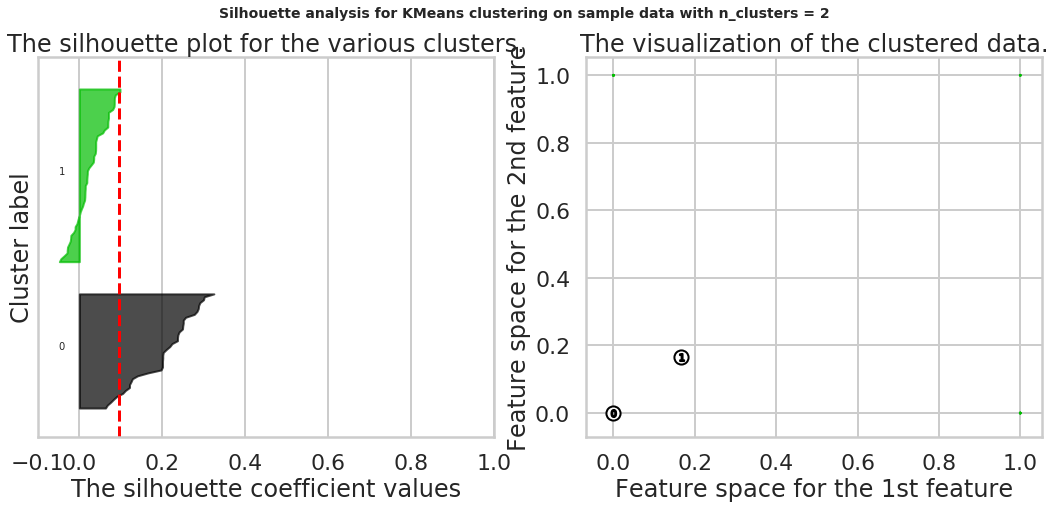

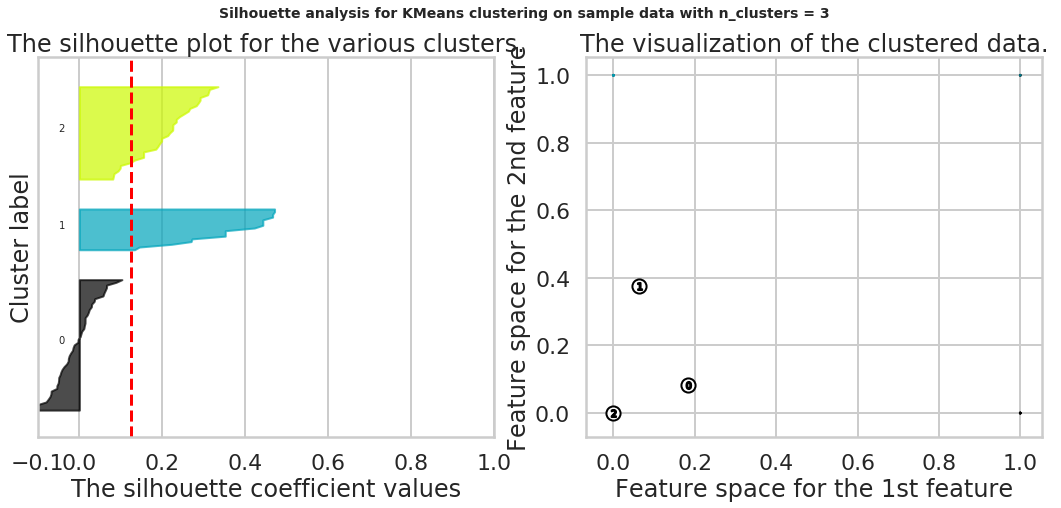

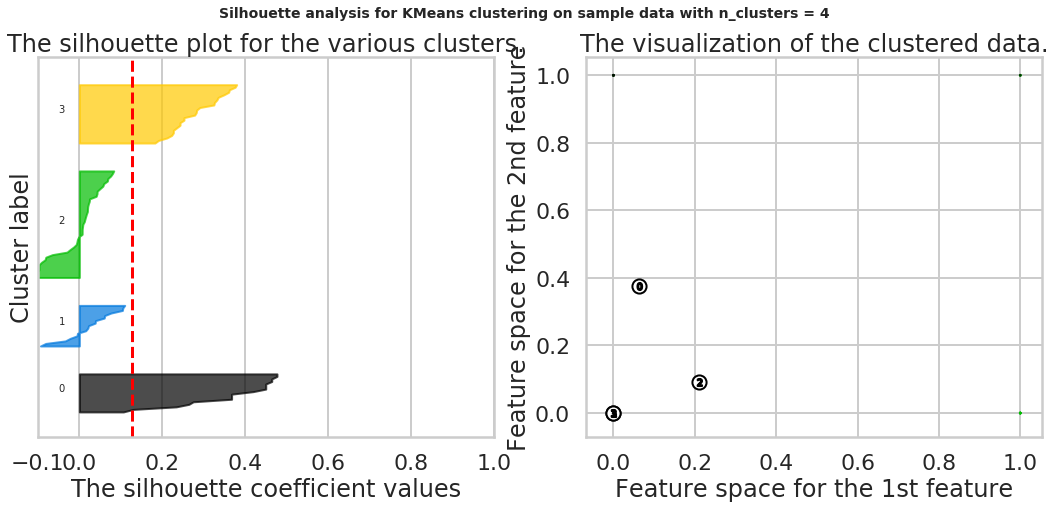

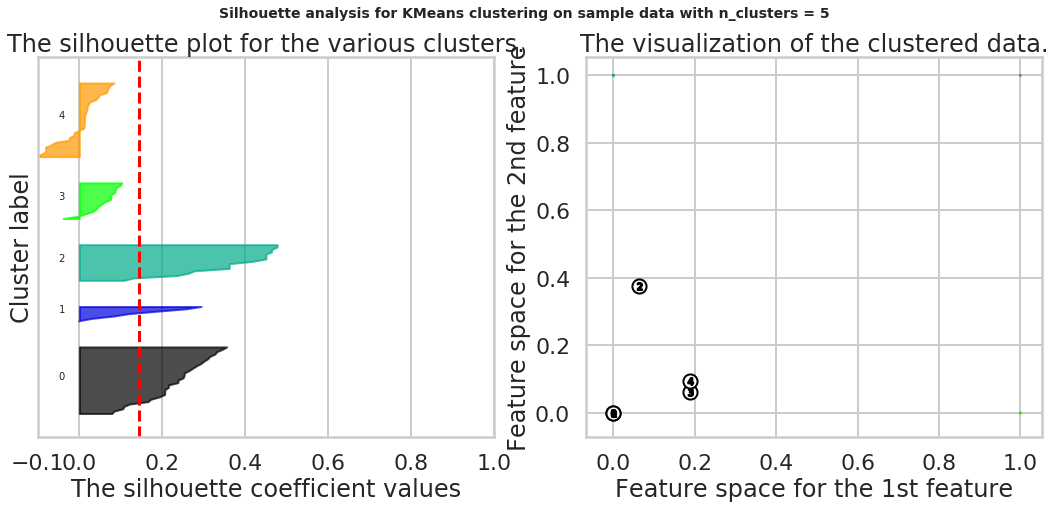

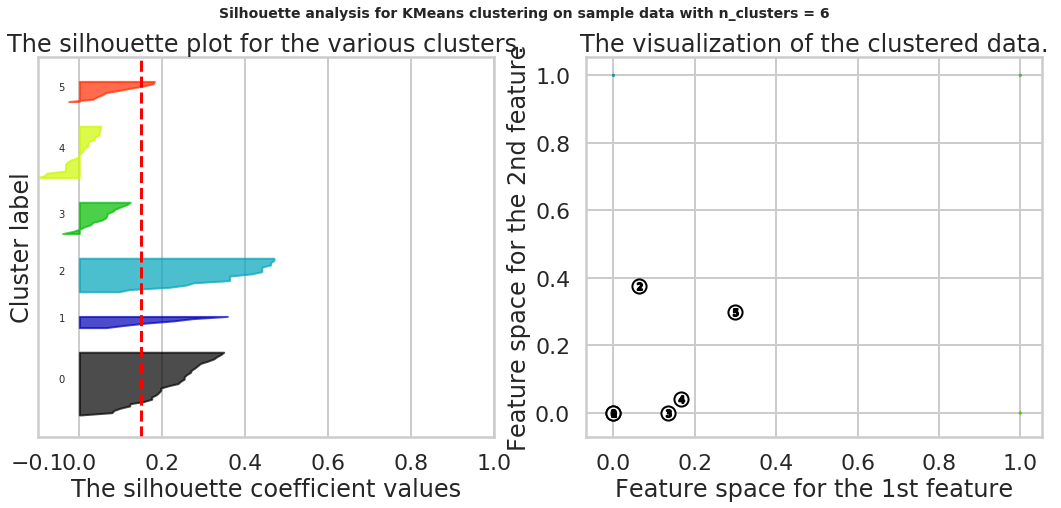

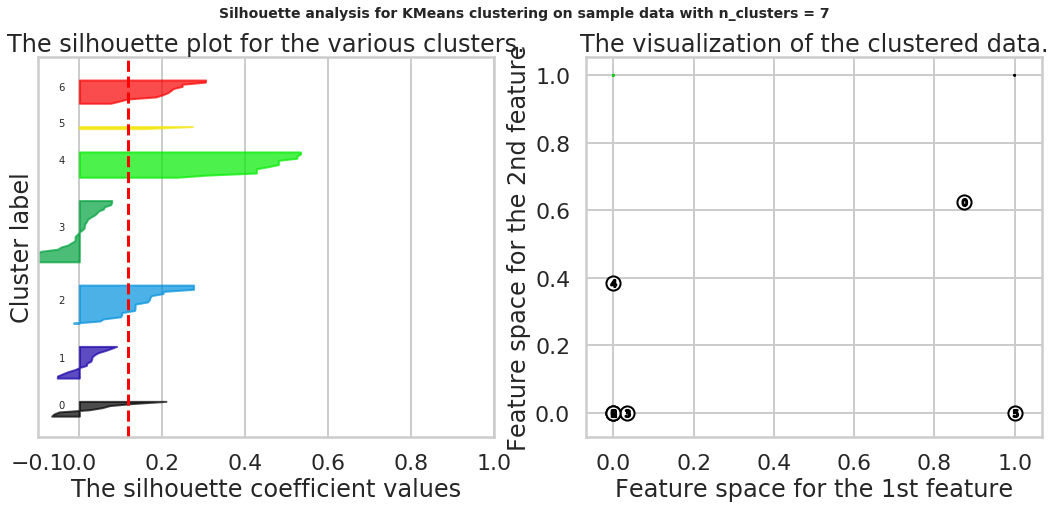

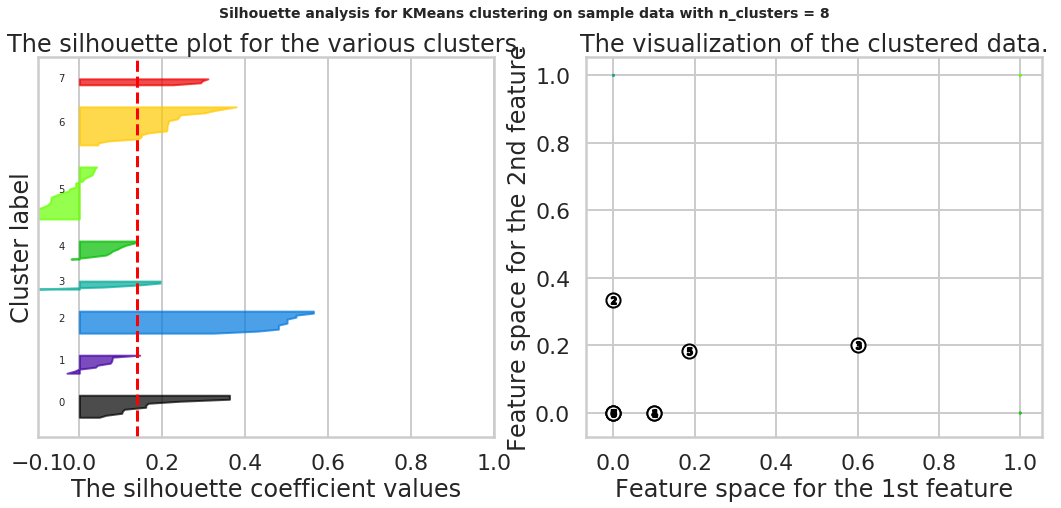

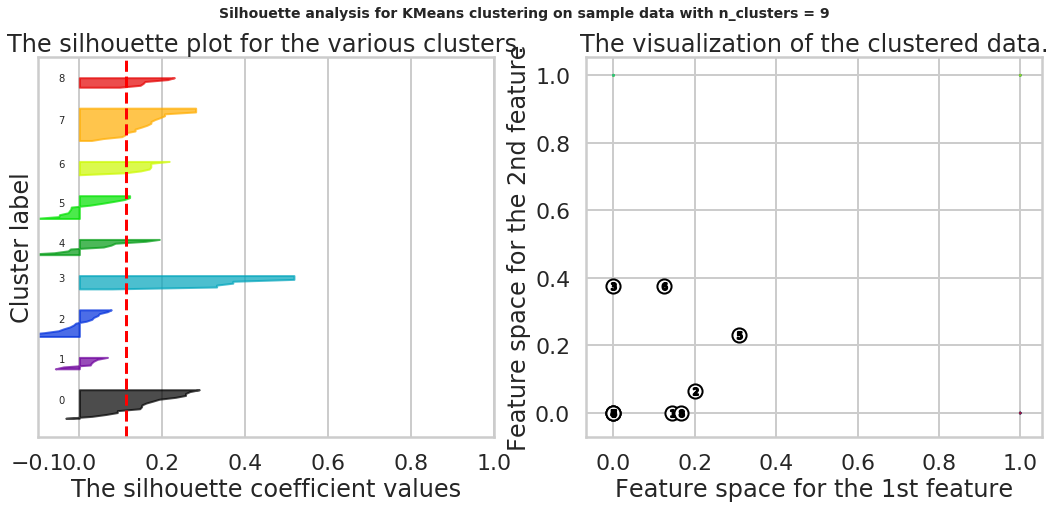

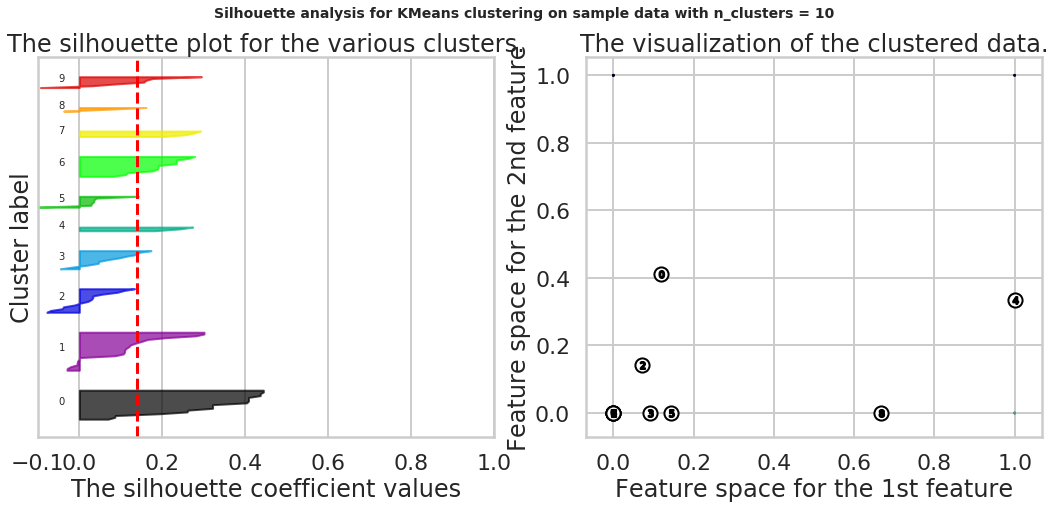

In [149]:
# Your turn.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(np.array(x_cols)) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(np.array(x_cols))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(np.array(x_cols), cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(np.array(x_cols), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(np.array(x_cols)[:, 0], np.array(x_cols)[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The highest silhouette score is for k = 6 (0.147), followed closely by k = 5 (0.143). While k = 5 could agree with the elbow method used previously, k = 6 would be considered to high.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [212]:
#your turn

# first reduce dimensionality to 2 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pd.DataFrame(pca.fit_transform(x_cols), columns=['x','y'])

# cluster pca components in to 4 clusters
model4 = KMeans(n_clusters=4, random_state=1)
cluster4_ids = pd.DataFrame(model4.fit_predict(components), columns=['cluster_id'])

# cluster pca components in to 5 clusters
model5 = KMeans(n_clusters=5, random_state=1)
cluster5_ids = pd.DataFrame(model5.fit_predict(components), columns=['cluster_id'])

# make datframe with customer name, id, and components for both 4 and 5 cluster models
df_cust_pca4 = pd.concat([x_cols.reset_index()['customer_name'], components, cluster4_ids], axis=1)


df_cust_pca5 = pd.concat([x_cols.reset_index()['customer_name'], components, cluster5_ids], axis=1)
df_cust_pca5.head()

,customer_name,x,y,cluster_id
0,Adams,1.006717,0.117787,3
1,Allen,-0.290151,0.040625,4
2,Anderson,-0.402963,1.032775,1
3,Bailey,0.698059,-0.018332,2
4,Baker,0.089292,-0.474131,0


Text(0.5, 1.0, '4 Cluster PCA')

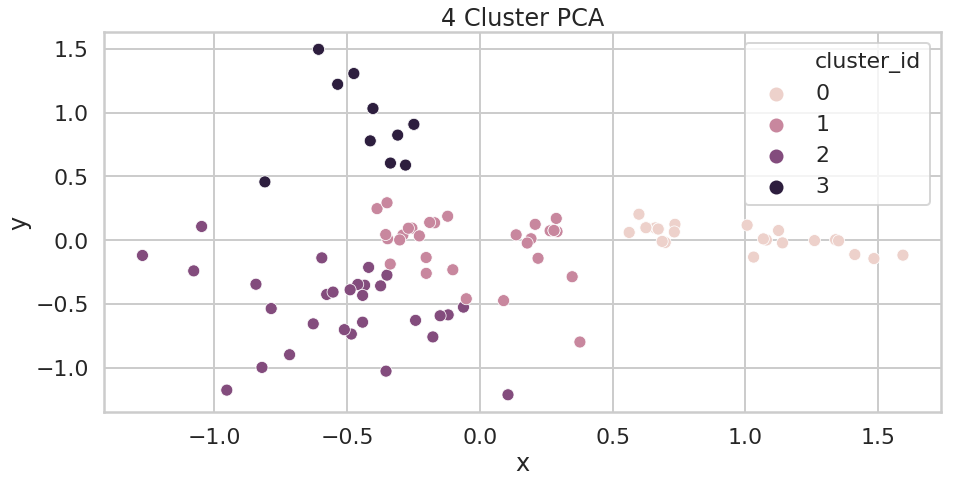

In [269]:
plt.figure(figsize=(15,7))
sns.scatterplot(data= df_cust_pca4, x='x', y='y', hue='cluster_id')
plt.title('4 Cluster PCA')

Text(0.5, 1.0, '5 Cluster PCA')

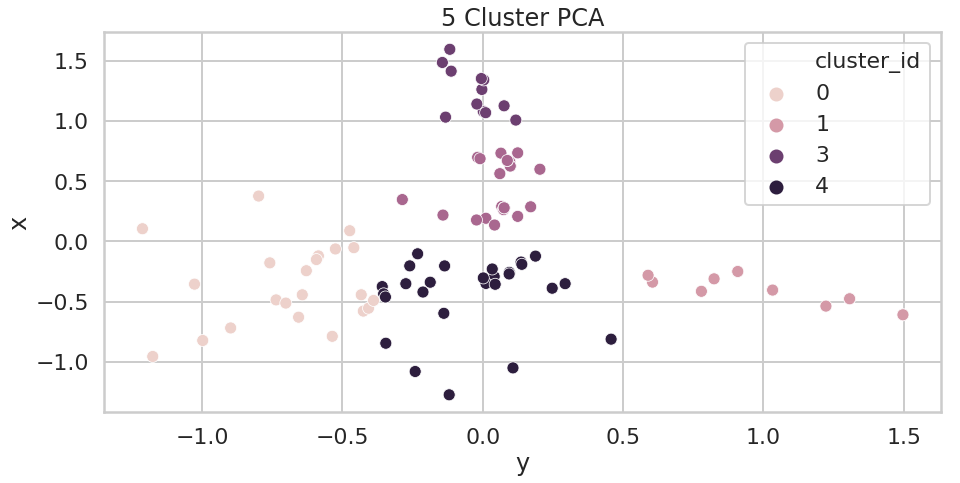

In [97]:
plt.figure(figsize=(15,7))
sns.scatterplot(data= df_cust_pca5, x='y', y='x', hue='cluster_id')
plt.title('5 Cluster PCA')

The clusters appear to be best grouped visually into either 4 or 5 clusters. If I had to choose one I would pick one based only off of the plot above I would choose the 4 cluster model. However the 5 cluster model agrees with both the elbow method and the silhouette method and also looks appealing visually as well.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

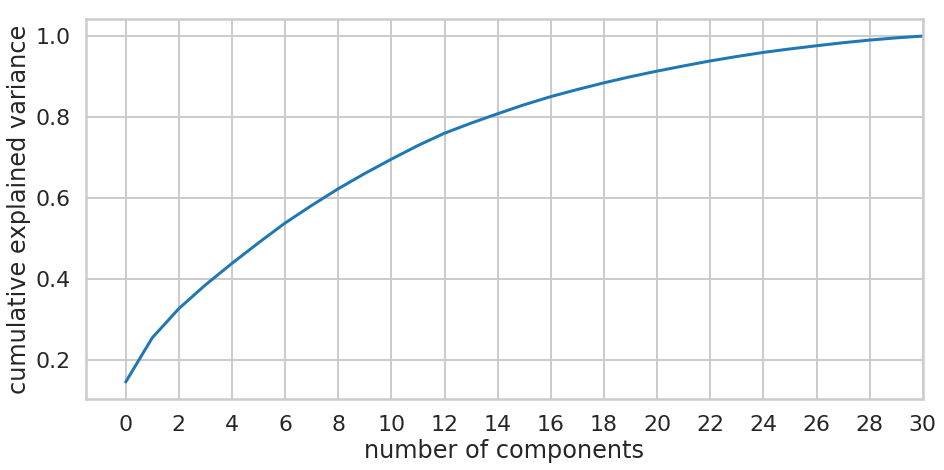

In [123]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

plt.figure(figsize=(15,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(right=30)
plt.xticks(range(0, 32, 2));


Doesn't really look like there is a clear elbow point. At 22 components though you still retain ~95% of the explained variance while reducing the number of components by about 30%.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


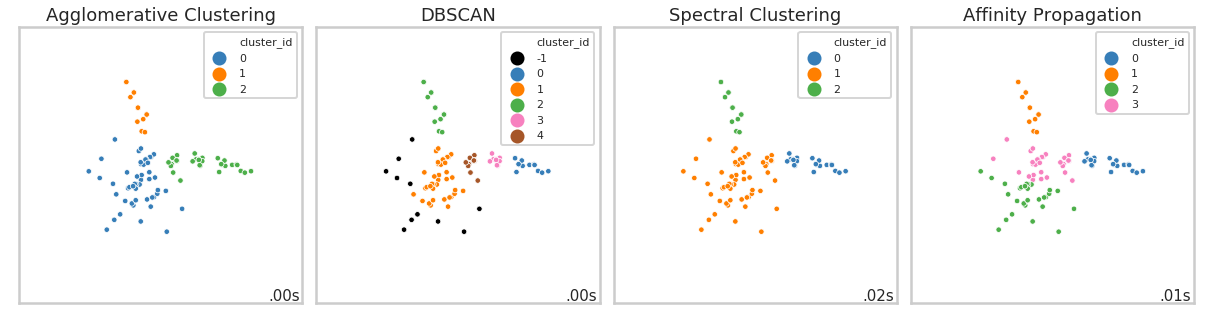

In [531]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


# Set up cluster parameters
plt.figure(figsize=(17, 4))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

X = np.array(components)

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# ‘ball_tree’, ‘kd_tree’, ‘brute’
# Create cluster objects
ward = cluster.AgglomerativeClustering(
    n_clusters=3, linkage='average')
spectral = cluster.SpectralClustering(
    n_clusters=3, eigen_solver='arpack',
    affinity="rbf", gamma=.25)
dbscan = cluster.DBSCAN(eps=.427)
affinity_propagation = cluster.AffinityPropagation(
    damping=.6, preference=-15)

clustering_algorithms = (
    
    ('Agglomerative Clustering', ward),
    ('DBSCAN', dbscan),
    ('Spectral Clustering', spectral),
    ('Affinity Propagation', affinity_propagation)
)

for name, algorithm in clustering_algorithms:
    t0 = time.time()
    
    # catch warnings related to spectral clustering
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    y_pred = algorithm.labels_.astype(np.int)

    plt.subplot(1, len(clustering_algorithms), plot_num)
    plt.title(name, size=18)
    
    colors = list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1)))
    # add black color for outliers (if any)
    if algorithm == dbscan:
        colors = ['#000000'] + colors
    
    cluster_ids = pd.DataFrame(algorithm.labels_, columns=['cluster_id'])
    df_cust_alg = pd.concat([x_cols.reset_index()['customer_name'], cluster_ids, components], axis=1)
    
    
    #plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred], label=colors)
    #plt.legend()
    sns.scatterplot(data= df_cust_alg, x='x', y='y', hue='cluster_id', palette=colors, s=30)
    plt.legend(loc='upper right', prop={'size': 11})
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.ylabel('')    
    plt.xlabel('')
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

As yhat mentions in his blog, the main motivation of customer segmentation is to identify different types of customers and then figure out ways to target more of those specific types of individuals so you can gain more customers. The trick here seems to be that you want to find the right balance between number of clusters and your marketing strategy. If you cluster smaller-tighter bunches it is likely that you will find more similarities between customers in those types of bunches, which will make targeting easier and therefore more likely to increase the clientele of that specific type of customer. However, if the clusters are too small and types are too specific then it will increase marketing costs to target more groups and the numbers of increase for each group will be smaller. Too large of clusters may be too mixed with different types of customers and therefore be harder to market to that cluster. 

Let's take a look at DBSCAN first since it has the most groups, then we can see how it compares with some the others.

## DBSCAN

In [490]:
# refit dbscan model and create dataframe of results
dbscan.fit(X)
cluster_ids = pd.DataFrame(dbscan.labels_, columns=['cluster_id'])
df_dbscan_clusters = pd.concat([x_cols.reset_index()['customer_name'], cluster_ids], axis=1)

In [491]:
# group clusters to analyze
cluster_offers = pd.concat([df_dbscan_clusters, df_cust_offers.reset_index(drop=True)], sort=True, axis=1)
cluster0 = cluster_offers[cluster_offers['cluster_id'] == 0]
cluster1 = cluster_offers[cluster_offers['cluster_id'] == 1]
cluster2 = cluster_offers[cluster_offers['cluster_id'] == 2]
cluster3 = cluster_offers[cluster_offers['cluster_id'] == 3]
cluster4 = cluster_offers[cluster_offers['cluster_id'] == 4]

In [492]:
print('Number of clients in cluster 0: {}'.format(cluster0.loc[:, (cluster0 != 0).any(axis=0)].shape[0]))
print('Cluster 0 Offers:')
df_offers[df_offers['offer_id'].isin(cluster0.loc[:, (cluster0 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 0: 12
Cluster 0 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
29,30,December,Malbec,6,54,France,False
12,13,May,Merlot,6,43,Chile,False
28,29,November,Pinot Grigio,6,87,France,False


Looks like all the offers that this cluster of clients accepted are for the lowest 'min_qty' that there has been, so this would be a good group to market for smaller purchases.

In [493]:
print('Number of clients in cluster 1: {}'.format(cluster1.loc[:, (cluster1 != 0).any(axis=0)].shape[0]))
print('Cluster 1 Offers:')
df_offers[df_offers['offer_id'].isin(cluster1.loc[:, (cluster1 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 1: 38
Cluster 1 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
14,15,June,Cabernet Sauvignon,144,19,Italy,False
27,28,November,Cabernet Sauvignon,12,56,France,True
24,25,October,Cabernet Sauvignon,72,59,Oregon,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
19,20,August,Cabernet Sauvignon,72,82,Italy,False
26,27,October,Champagne,72,88,New Zealand,False
21,22,August,Champagne,72,63,France,False
20,21,August,Champagne,12,50,California,False
18,19,July,Champagne,12,66,Germany,False
10,11,May,Champagne,72,85,France,False


This group seems to be more prone to buying Champagne and Cabernet Sauvignon.

In [494]:
print('Number of clients in cluster 2: {}'.format(cluster2.loc[:, (cluster2 != 0).any(axis=0)].shape[0]))
print('Cluster 2 Offers:')
df_offers[df_offers['offer_id'].isin(cluster2.loc[:, (cluster2 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 2: 15
Cluster 2 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
15,16,June,Merlot,72,88,California,False
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False
11,12,May,Prosecco,72,83,Australia,False


This cluster seems to mostly take advantage of offers on Pinot Noir and would be a good group to market for that type of wine.

In [495]:
print('Number of clients in cluster 3: {}'.format(cluster3.loc[:, (cluster3 != 0).any(axis=0)].shape[0]))
print('Cluster 3 Offers:')
df_offers[df_offers['offer_id'].isin(cluster3.loc[:, (cluster3 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 3: 12
Cluster 3 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
29,30,December,Malbec,6,54,France,False
12,13,May,Merlot,6,43,Chile,False
28,29,November,Pinot Grigio,6,87,France,False
6,7,March,Prosecco,6,40,Australia,True


This group seems to also only take advantage on small order promotions and seems like it should belong with cluster. 0

In [498]:
print('Number of clients in cluster 4: {}'.format(cluster4.loc[:, (cluster4 != 0).any(axis=0)].shape[0]))
print('Cluster 4 Offers:')
df_offers[df_offers['offer_id'].isin(cluster4.loc[:, (cluster4 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 4: 12
Cluster 4 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
24,25,October,Cabernet Sauvignon,72,59,Oregon,True
27,28,November,Cabernet Sauvignon,12,56,France,True
10,11,May,Champagne,72,85,France,False
20,21,August,Champagne,12,50,California,False
26,27,October,Champagne,72,88,New Zealand,False
8,9,April,Chardonnay,144,57,Chile,False
2,3,February,Espumante,144,32,Oregon,True
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
29,30,December,Malbec,6,54,France,False


There doesn't seem to be any notable trends for clients in cluster 4. 

Now lets take a look at Affinity Propagation and Spectral Clustering since they group clusters 0 and 3 from DBSCAN together which makes more since.

## Affinity Propagation

In [499]:
# refit affinity propagation model and create dataframe of results
affinity_propagation.fit(X)
cluster_ids = pd.DataFrame(affinity_propagation.labels_, columns=['cluster_id'])
df_aff_clusters = pd.concat([x_cols.reset_index()['customer_name'], cluster_ids], axis=1)

In [500]:
cluster_offers = pd.concat([df_aff_clusters, df_cust_offers.reset_index(drop=True)], sort=True, axis=1)
cluster0 = cluster_offers[cluster_offers['cluster_id'] == 0]
cluster1 = cluster_offers[cluster_offers['cluster_id'] == 1]
cluster2 = cluster_offers[cluster_offers['cluster_id'] == 2]
cluster3 = cluster_offers[cluster_offers['cluster_id'] == 3]

In [501]:
print('Number of clients in cluster 0: {}'.format(cluster0.loc[:, (cluster0 != 0).any(axis=0)].shape[0]))
print('Cluster 0 Offers:')
df_offers[df_offers['offer_id'].isin(cluster0.loc[:, (cluster0 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 0: 24
Cluster 0 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
29,30,December,Malbec,6,54,France,False
12,13,May,Merlot,6,43,Chile,False
28,29,November,Pinot Grigio,6,87,France,False


The group that took advantage of small order offers, now twice as many clients.

In [502]:
print('Number of clients in cluster 1: {}'.format(cluster1.loc[:, (cluster1 != 0).any(axis=0)].shape[0]))
print('Cluster 1 Offers:')
df_offers[df_offers['offer_id'].isin(cluster1.loc[:, (cluster1 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 1: 15
Cluster 1 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
15,16,June,Merlot,72,88,California,False
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False
11,12,May,Prosecco,72,83,Australia,False


Group that took advantage of mostly Pinot Noir offers.

In [503]:
print('Number of clients in cluster 2: {}'.format(cluster2.loc[:, (cluster2 != 0).any(axis=0)].shape[0]))
print('Cluster 2 Offers:')
df_offers[df_offers['offer_id'].isin(cluster2.loc[:, (cluster2 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 2: 28
Cluster 2 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
19,20,August,Cabernet Sauvignon,72,82,Italy,False
27,28,November,Cabernet Sauvignon,12,56,France,True
14,15,June,Cabernet Sauvignon,144,19,Italy,False
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
24,25,October,Cabernet Sauvignon,72,59,Oregon,True
20,21,August,Champagne,12,50,California,False
21,22,August,Champagne,72,63,France,False
10,11,May,Champagne,72,85,France,False
30,31,December,Champagne,72,89,France,False
26,27,October,Champagne,72,88,New Zealand,False


In [504]:
print('Number of clients in cluster 3: {}'.format(cluster3.loc[:, (cluster3 != 0).any(axis=0)].shape[0]))
print('Cluster 3 Offers:')
df_offers[df_offers['offer_id'].isin(cluster3.loc[:, (cluster3 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 3: 33
Cluster 3 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
14,15,June,Cabernet Sauvignon,144,19,Italy,False
27,28,November,Cabernet Sauvignon,12,56,France,True
24,25,October,Cabernet Sauvignon,72,59,Oregon,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
19,20,August,Cabernet Sauvignon,72,82,Italy,False
26,27,October,Champagne,72,88,New Zealand,False
21,22,August,Champagne,72,63,France,False
20,21,August,Champagne,12,50,California,False
18,19,July,Champagne,12,66,Germany,False
10,11,May,Champagne,72,85,France,False


The last 2 clusters actually look very similar and seem like they should be grouped together as shown in Spectral Clustering. Therefore, based off these results I think Spectral Clustering performs the best here. This way you would have two targeted groups for small orders, and Pinot Noir, and a more general group of clients that prefer more offers on Champagne, Cabernet Sauvignon, and Prosecco. Let's see what the final clusters look like below.

In [538]:
# refit spectral clustering model and create dataframe of results

spectral.fit(X)
cluster_ids = pd.DataFrame(spectral.labels_, columns=['cluster_id'])
df_spec_clusters = pd.concat([x_cols.reset_index()['customer_name'], cluster_ids], axis=1)

In [539]:
cluster_offers = pd.concat([df_spec_clusters, df_cust_offers.reset_index(drop=True)], sort=True, axis=1)
cluster0 = cluster_offers[cluster_offers['cluster_id'] == 0]
cluster1 = cluster_offers[cluster_offers['cluster_id'] == 1]
cluster2 = cluster_offers[cluster_offers['cluster_id'] == 2]
cluster3 = cluster_offers[cluster_offers['cluster_id'] == 3]

In [540]:
print('Number of clients in cluster 0: {}'.format(cluster0.loc[:, (cluster0 != 0).any(axis=0)].shape[0]))
print('Cluster 0 Offers:')
df_offers[df_offers['offer_id'].isin(cluster0.loc[:, (cluster0 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 0: 24
Cluster 0 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
29,30,December,Malbec,6,54,France,False
12,13,May,Merlot,6,43,Chile,False
28,29,November,Pinot Grigio,6,87,France,False


The group that took advantage of small order promotions.

In [543]:
print('Number of clients in cluster 1: {}'.format(cluster1.loc[:, (cluster1 != 0).any(axis=0)].shape[0]))
print('Cluster 1 Offers:')
df_offers[df_offers['offer_id'].isin(cluster1.loc[:, (cluster1 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 1: 61
Cluster 1 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
14,15,June,Cabernet Sauvignon,144,19,Italy,False
27,28,November,Cabernet Sauvignon,12,56,France,True
24,25,October,Cabernet Sauvignon,72,59,Oregon,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
19,20,August,Cabernet Sauvignon,72,82,Italy,False
26,27,October,Champagne,72,88,New Zealand,False
21,22,August,Champagne,72,63,France,False
20,21,August,Champagne,12,50,California,False
18,19,July,Champagne,12,66,Germany,False
10,11,May,Champagne,72,85,France,False


The more general group that took advantage of offers mostly on Champagne, Cabernet Sauvignon, and Prosecco.

In [544]:
print('Number of clients in cluster 2: {}'.format(cluster2.loc[:, (cluster2 != 0).any(axis=0)].shape[0]))
print('Cluster 2 Offers:')
df_offers[df_offers['offer_id'].isin(cluster2.loc[:, (cluster2 != 0).any(axis=0)].columns[2:])].sort_values('varietal')

Number of clients in cluster 2: 15
Cluster 2 Offers:


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
15,16,June,Merlot,72,88,California,False
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False
11,12,May,Prosecco,72,83,Australia,False


And lastly the group that mostly took advantage offers on Pinot Noir.